# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/open?id=1mvtmcfyLtNVoJ2VNUgwK6rq_NfKYLsWy

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

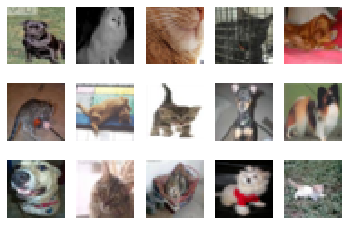

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
catTestCount = 0
dogTestCount = 0

catTrainCount = 0
dogTrainCount = 0

catValCount = 0
dogValCount = 0

for images, labels in train_loader:
  for label in labels:
    if label == 3:
      catTrainCount += 1
    elif label == 5:
      dogTrainCount += 1

for images, labels in test_loader:
  for label in labels:
    if label == 3:
      catTestCount += 1
    elif label == 5:
      dogTestCount += 1

for images, labels in val_loader:
  for label in labels:
    if label == 3:
      catValCount += 1
    elif label == 5:
      dogValCount += 1
    
print("Cat Train Count:", str(catTrainCount))
print("Dog Train Count:", str(dogTrainCount))

print("Cat Test Count:", str(catTestCount))
print("Dog Test Count:", str(dogTestCount))

print("Cat Validation Count:", str(catValCount))
print("Dog Validation Count:", str(dogValCount))

Cat Train Count: 4018
Dog Train Count: 3982
Cat Test Count: 1000
Dog Test Count: 1000
Cat Validation Count: 982
Dog Validation Count: 1018


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation test to make sure that the model does well on images which it hasn't been directly trained on. If we only look at maximizing the performance of the model on the training set, we will overfit the model to just the images on the training set - resulting in worse performance on images the model hasn't seen.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
small_net_params = 0
large_net_params = 0

for params in small_net.parameters():
  small_net_params += params.numel()

for params in large_net.parameters():
  large_net_params += params.numel()

print("The small network has %d paramaters." % small_net_params)
print("The large network has %d paramaters." % large_net_params)

The small network has 386 paramaters.
The large network has 9705 paramaters.


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

The default value of `batch_size` is 64.
The default value of `learning_rate` is 0.01.
The default value of `num_epochs` is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.



*   5 model checkpoints (saved values of the model parameters) will be saved after each epoch is completed
*   A file with the error values of the model on the training set after each epoch will be saved
*   A file with the error values of the model on the validation set after each epoch will be saved
*   A file with the loss values of the model on the training set after each epoch will be saved
*   A file with the loss values of the model on the validation set after each epoch will be saved



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_net(small_net)

train_net(large_net)

print("The small network took 83.77 seconds to train.")
print("The large network took 95.98 seconds to train.")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42625, Train loss: 0.6741164255142212 |Validation err: 0.381, Validation loss: 0.6582100167870522
Epoch 2: Train err: 0.375, Train loss: 0.6526135597229004 |Validation err: 0.386, Validation loss: 0.6680544335395098
Epoch 3: Train err: 0.362625, Train loss: 0.6395990414619446 |Validation err: 0.3565, Validation loss: 0.6281468980014324
Epoch 4: Train err: 0.350625, Train loss: 0.6258791666030884 |Validation err: 0.352, Validation loss: 0.6252050884068012
Epoch 5: Train err: 0.341625, Train loss: 0.6167933650016785 |Validation err: 0.341, Validation loss: 0.6181983556598425
Epoch 6: Train err: 0.326, Train loss: 0.6050077464580536 |Validation err: 0.343, Validation loss: 0.6138229854404926
Epoch 7: Train err: 0.32575, Train loss: 0.5985005292892456 |Validation err: 0.3235, Validation loss: 0.6034648381173611
Epoch 8: Train err: 0.322125, Train loss: 0.5904133405685424 |Validation err: 0.333

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Network:


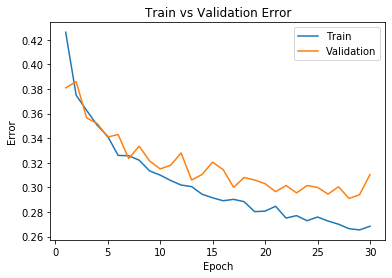

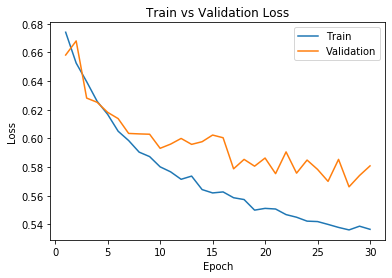

Large Network:


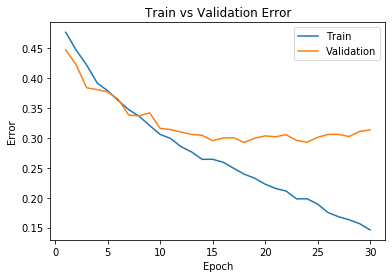

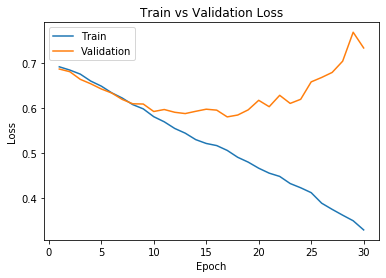

In [0]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("Small Network:")
plot_training_curve(small_model_path)
print("Large Network:")
plot_training_curve(large_model_path)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curve for both the large and small network consistently decreases both the loss and error. This is because, for each pass through the training data, the parameters are slightly changed to improve the performance on the training data. However, after around 5 epochs on the large network (and after around 10 on the small network), it becomes evident that the validation curves stop decreasing consistently - and in the case of the large network validation loss, it actually starts rising! This is due to overfitting - the model is being trained only to predict the values on the training set, and if it's being trained too well for that task to the point that it loses its ability to generalize to other images.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360080718994 |Validation err: 0.467, Validation loss: 0.6924686636775732
Epoch 2: Train err: 0.44875, Train loss: 0.6922589583396912 |Validation err: 0.4305, Validation loss: 0.6916492655873299
Epoch 3: Train err: 0.43575, Train loss: 0.6916066603660583 |Validation err: 0.4285, Validation loss: 0.6908543165773153
Epoch 4: Train err: 0.430125, Train loss: 0.6908612747192383 |Validation err: 0.424, Validation loss: 0.6896593235433102
Epoch 5: Train err: 0.43425, Train loss: 0.6899194974899292 |Validation err: 0.4195, Validation loss: 0.6886938568204641
Epoch 6: Train err: 0.435625, Train loss: 0.6887412958145142 |Validation err: 0.4195, Validation loss: 0.6867822967469692
Epoch 7: Train err: 0.436875, Train loss: 0.6873781509399414 |Validation err: 0.4185, Validation loss: 0.6851989887654781
Epoch 8: Train err: 0.437375, Train loss: 0.6859279689788819 |Validation err

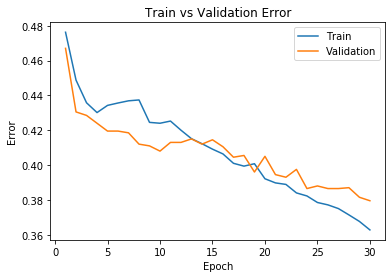

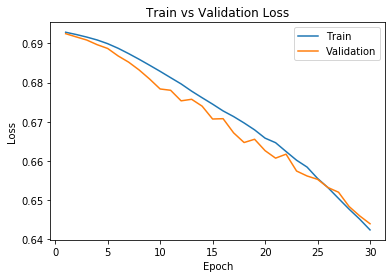

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)


After lowering the learning rate, the model took around the same amount of time to train: 94.79 seconds. However, the reduced learning rate helped decrease the degree of overfitting to the test set we saw in the earlier model. We can see that the validation loss/error continue to decrease with the training loss/error, and may even be slightly underfitted, as the validation error is higher than the validation error was with default parameters. This is because the parameters take smaller "steps" at each training iteration, so the model doesn't converge as quickly.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.430875, Train loss: 0.6745959863662719 |Validation err: 0.368, Validation loss: 0.6340839341282845
Epoch 2: Train err: 0.358625, Train loss: 0.6352161388397217 |Validation err: 0.3545, Validation loss: 0.6216924283653498
Epoch 3: Train err: 0.36225, Train loss: 0.6281572859287262 |Validation err: 0.3605, Validation loss: 0.6542215058580041
Epoch 4: Train err: 0.343, Train loss: 0.6126534929275512 |Validation err: 0.3455, Validation loss: 0.6298394948244095
Epoch 5: Train err: 0.320625, Train loss: 0.5912592806816102 |Validation err: 0.3305, Validation loss: 0.5954575091600418
Epoch 6: Train err: 0.30425, Train loss: 0.5770253727436065 |Validation err: 0.323, Validation loss: 0.6387462010607123
Epoch 7: Train err: 0.302125, Train loss: 0.5663205885887146 |Validation err: 0.324, Validation loss: 0.618142738007009
Epoch 8: Train err: 0.283125, Train loss: 0.5423468964099885 |Validation err: 0

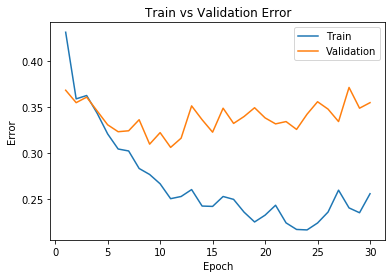

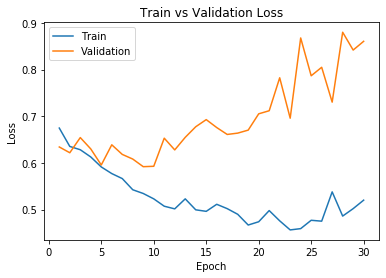

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

Increasing the learning rate didn't appear to have any significant effect on training time either, as it took 93.12 seconds. However, this clearly caused the model to overfit the training data a lot faster, as we can tell that both the validation loss and error start increasing instead of decreasing after just around 5 epochs of training.


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917424947023392
Epoch 3: Train err: 0.437, Train loss: 0.6916500329971313 |Validation err: 0.4265, Validation loss: 0.6909129470586777
Epoch 4: Train err: 0.433625, Train loss: 0.6908449530601501 |Validation err: 0.424, Validation loss: 0.6897872388362885
Epoch 5: Train err: 0.433875, Train loss: 0.6896938420832157 |Validation err: 0.424, Validation loss: 0.6881361752748489
Epoch 6: Train err: 0.438375, Train loss: 0.6883538104593754 |Validation err: 0.4285, Validation loss: 0.6860138773918152
Epoch 7: Train err: 0.4395, Train loss: 0.6866881810128689 |Validation err: 0.426, Validation loss: 0.6836974024772644
Epoch 8: Train err: 0.43525, Train loss: 0.6849779076874256 |Validation err: 0.41

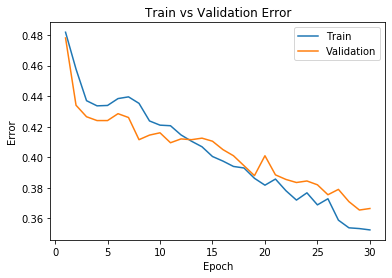

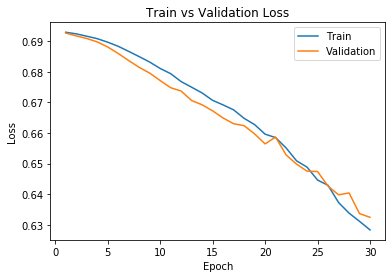

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size = 512)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

Increasing the batch size to 512 decreased the training time for the model to 84.02 seconds. This may be because the model needs to do less passes to cover the entire training set as it considers more data each time - this means that it needs to calculate the gradients and update weights less times. Furthermore, increasing the batch size appears to have caused the model to underfit the dataset as neither the training nor validation loss/error appear to be converging yet. This may be because the model is only updated based on its performance on a larger set of images, so it tries to improve on a more generalized set of images rather than a possibly smaller, more specific set of images that may all be similar to each other in a way that isn't representative of the entire dataset. In order to improve its performance, increasing the number of epochs may make it better than the other hyperparameter settings seen so far as it already performs well and doesn't appear to have been fully trained yet (ie. it looks underfitted).

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431625, Train loss: 0.6775330043435097 |Validation err: 0.3775, Validation loss: 0.6519424777030944
Epoch 2: Train err: 0.367625, Train loss: 0.6392622269392013 |Validation err: 0.348, Validation loss: 0.6155767557621002
Epoch 3: Train err: 0.339125, Train loss: 0.611388805270195 |Validation err: 0.3535, Validation loss: 0.6442605230808258
Epoch 4: Train err: 0.31, Train loss: 0.5834368724226952 |Validation err: 0.358, Validation loss: 0.627853533744812
Epoch 5: Train err: 0.30625, Train loss: 0.5661577586531639 |Validation err: 0.316, Validation loss: 0.5802795274257659
Epoch 6: Train err: 0.280625, Train loss: 0.5455610679984093 |Validation err: 0.305, Validation loss: 0.5808147265911102
Epoch 7: Train err: 0.268, Train loss: 0.5272379929423332 |Validation err: 0.3215, Validation loss: 0.5912406492233276
Epoch 8: Train err: 0.262875, Train loss: 0.5096900141835212 |Validation err: 0.305,

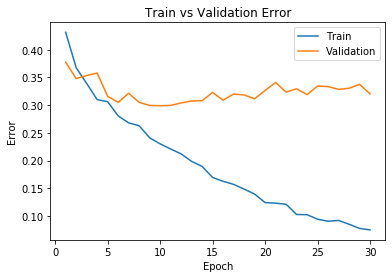

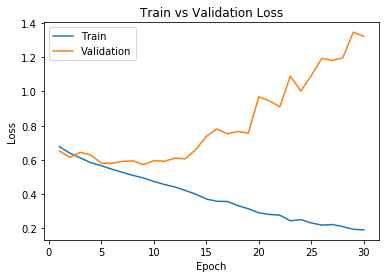

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size = 16)

large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

Decreasing the batch size increased the training time a lot, to 143.75 seconds, possibly as it means that the model needs to update its weights more often for the same number of epochs. Decreasing the batch size decreased both the validation and training error compared to the previous itration - but it is clearly an extremely overfitted model that is unlikely perform well on new data. The reason for being overfitted may be the opposite of the reason why I suggested the earlier model may have been underfitted.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I would use the large network with a batch size of 512 and a learning rate 0.001 as this will likely reduce the possibility of extreme overfitting on the training data. In order to make sure the model doesn't underfit either, I will greatly increase the number of epochs to 250.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.501, Train loss: 0.6930630952119827 |Validation err: 0.4925, Validation loss: 0.6930321753025055
Epoch 2: Train err: 0.500625, Train loss: 0.6930362991988659 |Validation err: 0.493, Validation loss: 0.6929764598608017
Epoch 3: Train err: 0.49825, Train loss: 0.6929608471691608 |Validation err: 0.495, Validation loss: 0.6929474025964737
Epoch 4: Train err: 0.497375, Train loss: 0.6928979605436325 |Validation err: 0.496, Validation loss: 0.6928962022066116
Epoch 5: Train err: 0.493875, Train loss: 0.6928219422698021 |Validation err: 0.5, Validation loss: 0.6928716003894806
Epoch 6: Train err: 0.4875, Train loss: 0.6927734613418579 |Validation err: 0.502, Validation loss: 0.6928212195634842
Epoch 7: Train err: 0.482625, Train loss: 0.6927070058882236 |Validation err: 0.499, Validation loss: 0.6927812248468399
Epoch 8: Train err: 0.48125, Train loss: 0.6926521398127079 |Validation err: 0.491, 

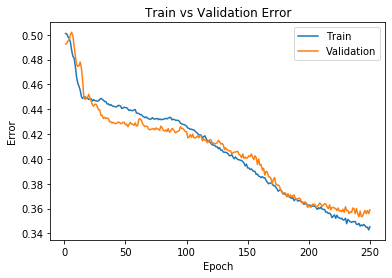

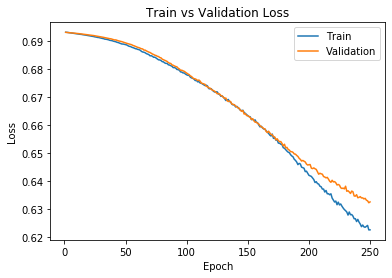

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001, batch_size = 512, num_epochs = 250)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=249)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Based on the results from Part (a), the model is still underfitting the training data as the validation loss hasn't begun to converge yet (ie. the function is still clearly decreasing). As such, I will keep the learning rate and batch size the same, and greatly increase the number of epochs to 500. Hopefully, at around 500 epochs, the validation loss function will have a slope close to zero, showing that it isn't underfitted anymore.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.485125, Train loss: 0.6928555369377136 |Validation err: 0.492, Validation loss: 0.6931210160255432
Epoch 2: Train err: 0.482875, Train loss: 0.692794032394886 |Validation err: 0.4895, Validation loss: 0.6930689811706543
Epoch 3: Train err: 0.479625, Train loss: 0.6927634328603745 |Validation err: 0.485, Validation loss: 0.693023294210434
Epoch 4: Train err: 0.478625, Train loss: 0.6927205510437489 |Validation err: 0.482, Validation loss: 0.6929885745048523
Epoch 5: Train err: 0.477, Train loss: 0.6926537938416004 |Validation err: 0.479, Validation loss: 0.6929118633270264
Epoch 6: Train err: 0.47025, Train loss: 0.6926201470196247 |Validation err: 0.478, Validation loss: 0.6928567141294479
Epoch 7: Train err: 0.465625, Train loss: 0.6925692930817604 |Validation err: 0.4715, Validation loss: 0.6928002387285233
Epoch 8: Train err: 0.457875, Train loss: 0.6925064399838448 |Validation err: 0.4

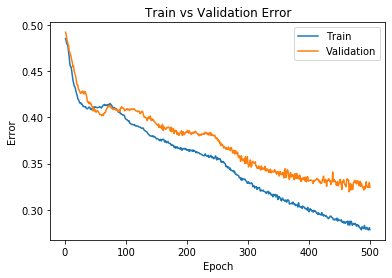

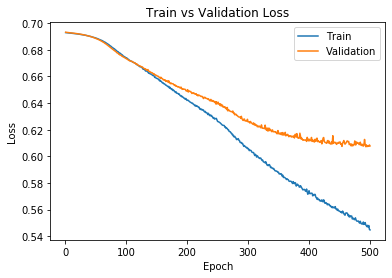

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001, batch_size = 512, num_epochs = 500)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=499)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=489)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose the last model I trained as it had the best performance on the validation set without overfitting - ie. neither the validation loss curve nor the validation error curve showed an upwards slope. Instead, the slopes were approaching zero which makes me believe that the model is neither underfitted nor overfitted.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(net, test_loader, criterion)

print("The error rate on the test set is {} and the loss on the test set is {}.".format(testError, testLoss))

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is 0.312 and the loss on the test set is 0.5946136061102152.


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

You would expect the test error to be higher than the validation error since the model chosen was the one which performed the best on the validation set - ie. even though the model wasn't directly trained on the validation set, it was chosen due to its performance on the validation set so it is likely that it performs better on that set than any arbitrary dataset. However, in this case, that turned out not to be true, as the model had a error rate of 0.312 on the test set, which is better than the error on the validation set (0.3215). This may be due to the images in the test set, if they were more similar to the images in the training set than in the validation set. Either way, I believe that it shows the model I trained is extremely robust in terms of performance on unseen data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In order to truly evaluate our models, we need to see how they perform on new/unseen data, as that is how they will be used in the real world. If we used the test data in order to help choose the model (ie. not leaving it for the very end), then it is no longer "new" data since we've used it to help design the model. As such, we no longer have any data to use to evaluate how our model performs in the real world.

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

In [0]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = x.squeeze(1)
        return x

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.688879020512104 |Validation err: 0.434, Validation loss: 0.6797744333744049
Epoch 2: Train err: 0.414625, Train loss: 0.6752726919949055 |Validation err: 0.4135, Validation loss: 0.6708007454872131
Epoch 3: Train err: 0.400375, Train loss: 0.6676484048366547 |Validation err: 0.4145, Validation loss: 0.666789636015892
Epoch 4: Train err: 0.39575, Train loss: 0.6625648327171803 |Validation err: 0.402, Validation loss: 0.6631308794021606
Epoch 5: Train err: 0.393, Train loss: 0.6582126542925835 |Validation err: 0.397, Validation loss: 0.6609072387218475
Epoch 6: Train err: 0.389875, Train loss: 0.6553298272192478 |Validation err: 0.3925, Validation loss: 0.6584004461765289
Epoch 7: Train err: 0.384125, Train loss: 0.6520302444696426 |Validation err: 0.395, Validation loss: 0.6575248539447784
Epoch 8: Train err: 0.381625, Train loss: 0.6491567753255367 |Validation err: 0.

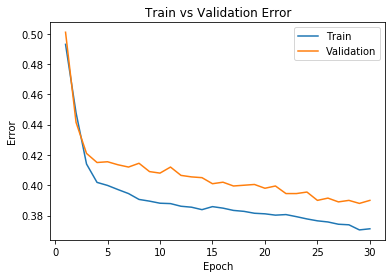

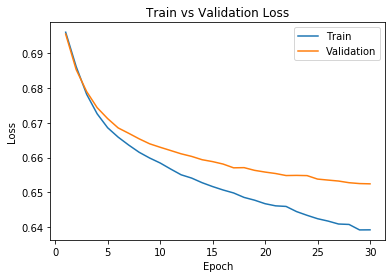

In [9]:
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.003, num_epochs=30)

ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

In [10]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(ANN_net, test_loader, criterion)

print("The error rate on the test set is {} and the loss on the test set is {}.".format(testError, testLoss))

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is 0.373 and the loss on the test set is 0.6444997638463974.


The 2 layer ANN architecture did not perform as well as the CNN architecture - no matter what hyperparameters I tried, I was not able to get the validation error below around 38% without heavily overfitting the training set. This can be shown as the performance on the test set was an error rate of 37.3%, while the CNN architecture I used had a far lower error rate of 31.2%.